In [1]:
import optuna    
import mlflow
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import catboost as cb
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, classification_report

/workspaces/sm-internship/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv('diabetes_dataset.csv')
df.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


In [3]:
df.describe() # statistical summary

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
count,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000
mean,53.577584,7.986161,27.052364,106.104183,84.475781,4.650661,100.133456,49.953418,151.147746,93.951678,103.060621,0.917400,0.302474,0.486161,0.001048,0.405012,0.344097
std,20.764651,4.933469,5.927955,21.918590,14.123480,0.476395,29.911910,15.242194,48.951627,15.594468,13.438827,0.140828,0.459354,0.661139,0.032364,0.490920,0.475098
min,18.000000,0.000000,15.000000,50.000000,60.000000,4.000000,-12.000000,-9.200000,50.000000,40.300000,54.800000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,4.000000,22.870000,91.000000,74.000000,4.300000,80.100000,39.700000,117.200000,83.400000,94.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,8.000000,27.050000,106.000000,84.000000,4.600000,99.900000,50.200000,150.550000,93.800000,103.200000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.000000,12.000000,31.180000,121.000000,94.000000,5.000000,120.200000,60.200000,185.100000,104.600000,112.100000,1.010000,1.000000,1.000000,0.000000,1.000000,1.000000
max,89.000000,16.000000,49.660000,207.200000,138.000000,6.900000,202.200000,107.800000,345.800000,163.000000,156.600000,1.490000,1.000000,2.000000,1.000000,1.000000,1.000000


In [4]:
df.info() # Check for data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  MedicationUse       9538 non-null   int64  
 16  Outcom

## EDA

In [5]:
# Divide numerical and categorical columns
num_columns = ['Age', 'Pregnancies']
num_columns.extend(df.select_dtypes(include='float').columns.to_list())
cat_columns = ['FamilyHistory', 'DietType', 'Hypertension', 'MedicationUse']

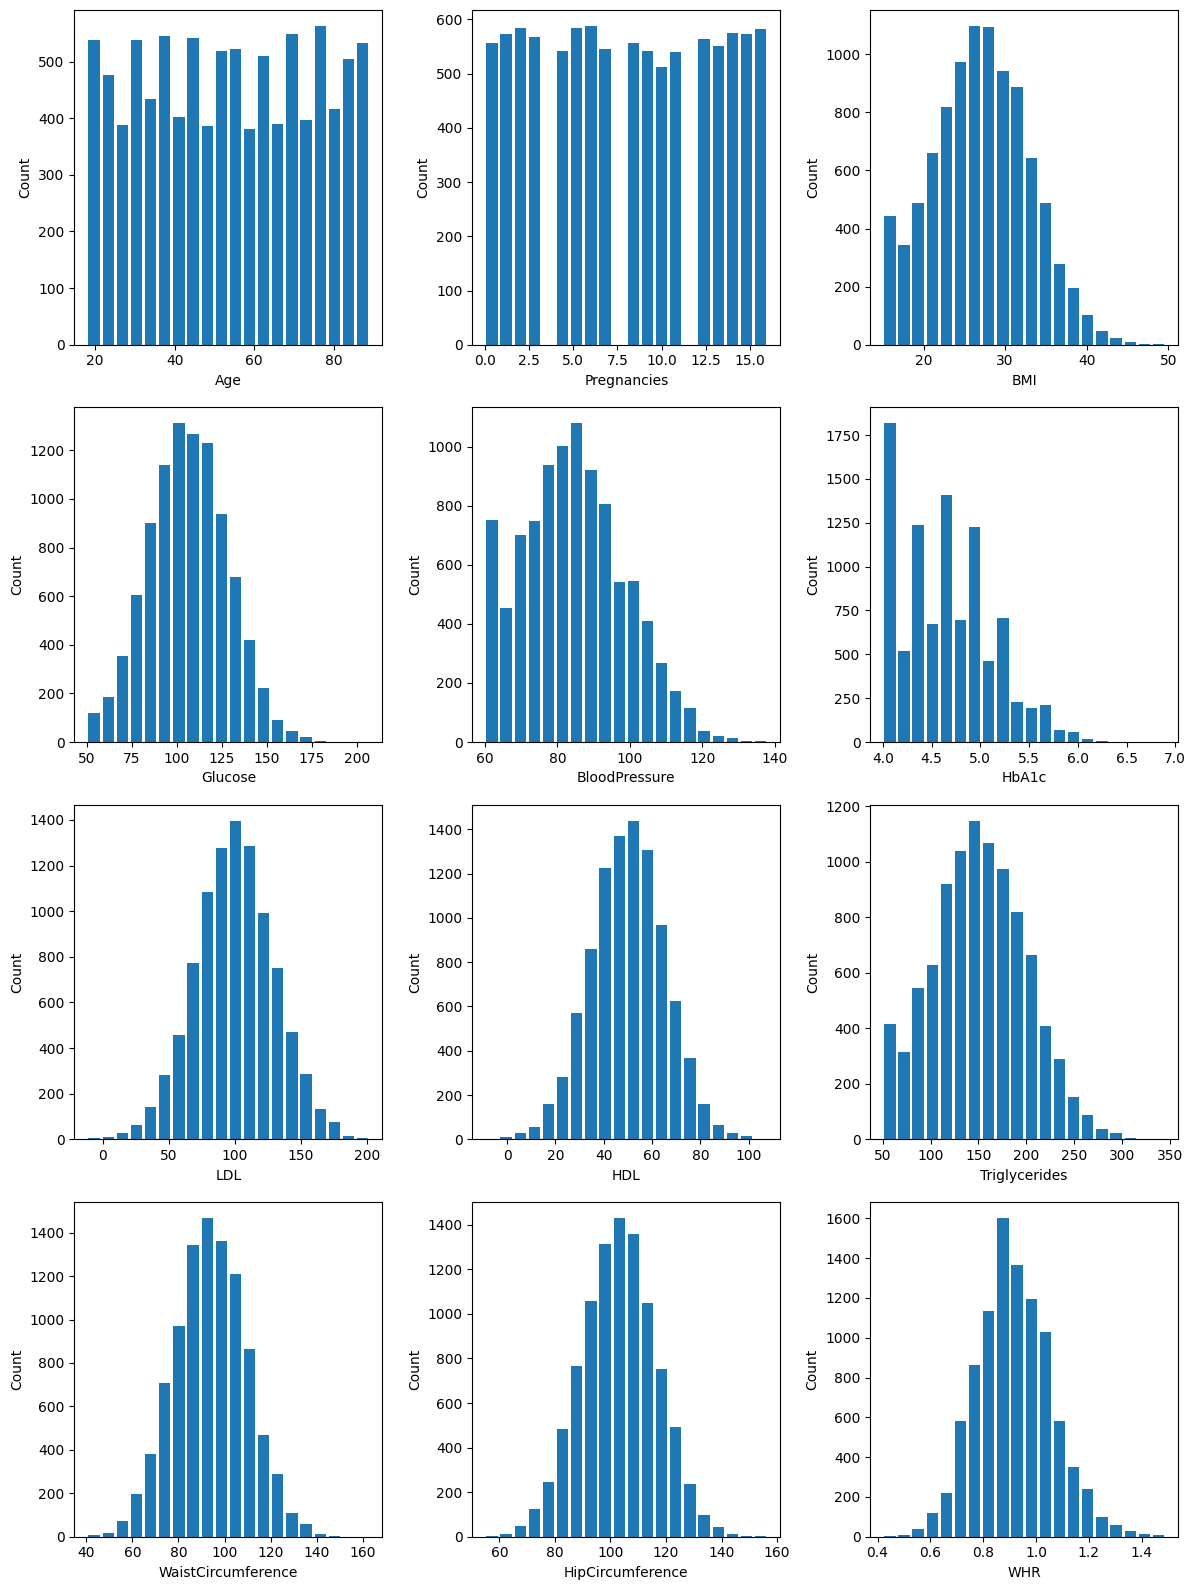

In [6]:
# Visualize the distribution of numerical columns
num_cols = len(num_columns)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, min(num_cols, 3), figsize=(12, 4*num_rows))

col_index = 0
for i, col in enumerate(num_columns):
    row_index = col_index // 3
    col_index_subplot = col_index % 3

    ax = axes[row_index, col_index_subplot]

    ax.hist(df[col], bins=20, rwidth=0.8)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    col_index +=1

plt.tight_layout()
plt.show()

<Axes: >

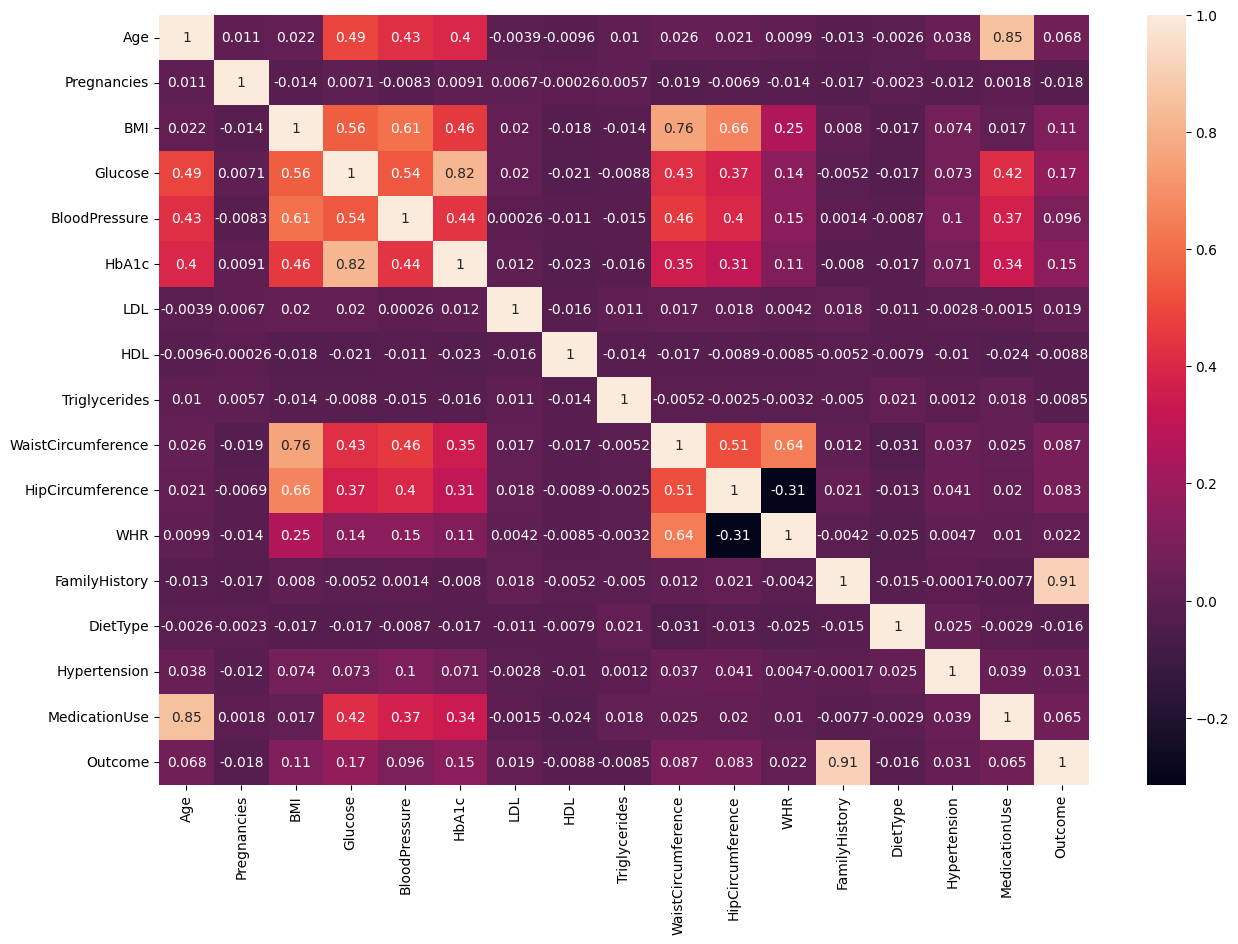

In [7]:
# Check the correlation of dataset
plt.figure(figsize = (15,10))
sns.heatmap(data=df.corr(),annot=True)

## Data Preprocessing

In [8]:
threshold = 0.05

variances = df.var()

quasi_constant_features = variances[variances <= threshold].index
print("Quasi-constant features:")
print(quasi_constant_features)


Quasi-constant features:
Index(['WHR', 'Hypertension'], dtype='object')


In [9]:
df.drop(['Hypertension', 'WHR'], axis=1, inplace = True)
cat_columns.remove('Hypertension')

In [10]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 20))

Top Absolute Correlations
FamilyHistory       Outcome               0.909166
Age                 MedicationUse         0.852709
Glucose             HbA1c                 0.817493
BMI                 WaistCircumference    0.761734
                    HipCircumference      0.662458
                    BloodPressure         0.605405
                    Glucose               0.556683
Glucose             BloodPressure         0.541987
WaistCircumference  HipCircumference      0.512328
Age                 Glucose               0.487808
BloodPressure       WaistCircumference    0.460178
BMI                 HbA1c                 0.459852
BloodPressure       HbA1c                 0.444980
Age                 BloodPressure         0.429335
Glucose             WaistCircumference    0.428944
                    MedicationUse         0.415119
BloodPressure       HipCircumference      0.400626
Age                 HbA1c                 0.396354
Glucose             HipCircumference      0.372786
Blood

In [11]:
df.drop(['Age', 'MedicationUse', 'BMI'], axis=1, inplace = True)
cat_columns.remove('MedicationUse')

In [ ]:
# Check if there is any categorical feature that is independent of the target variable
for col in cat_columns:
    contingency_table = pd.crosstab(df[col], df["Outcome"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Feature: {col}")
    print(f"P-value: {p:.4f} which is {'less than' if p < 0.05 else 'greater than'} 0.05")
    print("-" * 75)


Feature: FamilyHistory
P-value: 0.0000 which is less than 0.05
---------------------------------------------------------------------------


In [13]:
df.drop('DietType', axis=1, inplace=True)
cat_columns.remove('DietType')

## BUILDING A MODEL WITH THE HELP OF OPTUNA AND TRACKING WITH MLFLOW

In [ ]:
# Creating mlflow server
mlflow.set_tracking_uri("http://localhost:5000")

In [19]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)
    
experiment_id = get_or_create_experiment("Diabetes catboost")
experiment_id

'432499792877561849'

In [20]:
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/432499792877561849', creation_time=1740932995368, experiment_id='432499792877561849', last_update_time=1740932995368, lifecycle_stage='active', name='Diabetes catboost', tags={}>

In [21]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [22]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
def objective(trial):
    with mlflow.start_run(nested=True):

        param = {
            "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
            "depth": trial.suggest_int("depth", 1, 12),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
            "used_ram_limit": "6gb",
        }

        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        catboost = cb.CatBoostClassifier(**param)

        catboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

        preds = catboost.predict(X_test)
        pred_labels = np.rint(preds)
        
        score = roc_auc_score(y_test, pred_labels)
        report_dict = classification_report(y_test, pred_labels, output_dict=True)

        mlflow.log_params(param)
        mlflow.log_metric("roc_auc_score", score)
        mlflow.log_metrics({
            'accuracy': report_dict['accuracy'],
            'recall_class_0': report_dict['0']['recall'],
            'recall_class_1': report_dict['1']['recall'],
            'f1_score_macro': report_dict['macro avg']['f1-score']
        })


    return score

In [25]:
run_name = "third_catboost_atempt"

In [26]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_roc_auc_score", study.best_value)

    mlflow.set_tags(
        tags={
            "project": "Diabetes",
            "optimizer_engine": "optuna",
            "model_family": "catboost",
            "feature_set_version": 1,
        }
    )    

    model = cb.CatBoostClassifier(**study.best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=0, early_stopping_rounds=100)

    artifact_path = "model"
    mlflow.catboost.log_model(
        cb_model=model,
        input_example=X_train.iloc[[0]],
        artifact_path=artifact_path
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

🏃 View run industrious-bass-740 at: http://localhost:5000/#/experiments/432499792877561849/runs/a7c83b56d7d242bb826ba8437cde872a
🧪 View experiment at: http://localhost:5000/#/experiments/432499792877561849
Initial trial 0 achieved value: 0.9992101105845181
🏃 View run peaceful-moth-59 at: http://localhost:5000/#/experiments/432499792877561849/runs/8c61f1b55d3145e9b27bbb73eba4cb45
🧪 View experiment at: http://localhost:5000/#/experiments/432499792877561849
🏃 View run legendary-ray-884 at: http://localhost:5000/#/experiments/432499792877561849/runs/dd4c42293d574bce9ea82f3c67bb536a
🧪 View experiment at: http://localhost:5000/#/experiments/432499792877561849
🏃 View run painted-horse-742 at: http://localhost:5000/#/experiments/432499792877561849/runs/b0eab7a20c1c4e7e8eb7280e4b8998ab
🧪 View experiment at: http://localhost:5000/#/experiments/432499792877561849
🏃 View run able-quail-880 at: http://localhost:5000/#/experiments/432499792877561849/runs/223c92735e1c4d819627c279be8abbd9
🧪 View exper

/workspaces/sm-internship/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run third_catboost_atempt at: http://localhost:5000/#/experiments/432499792877561849/runs/78e8b2ea4b664bf68041da96ed42fc19
🧪 View experiment at: http://localhost:5000/#/experiments/432499792877561849


In [ ]:
# Load the best model from the artifact store
loaded = mlflow.catboost.load_model(model_uri)

# Exploring features importance with SHAP 

In [29]:
shap.initjs()
explainer = shap.Explainer(loaded)
shap_values = explainer(X_test)

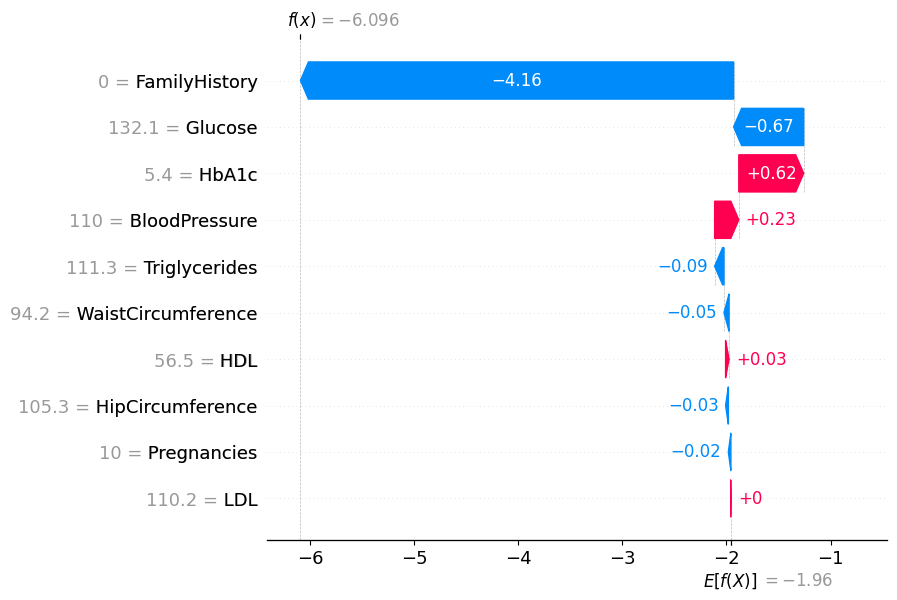

In [30]:
shap.plots.waterfall(shap_values[0])

### Explainig of result

*   Family history is the most imortant feature. This feature has the highest impact on the model's negative prediction. 
*   Glucose also has an impact to the prediction, but it is less than family history.
*   HbA1c has an impact for positive prediction, but it's not too high for negative prediction.
*   The rest of the features have a very small impact on the prediction, so they can be ignored next time for the model training.


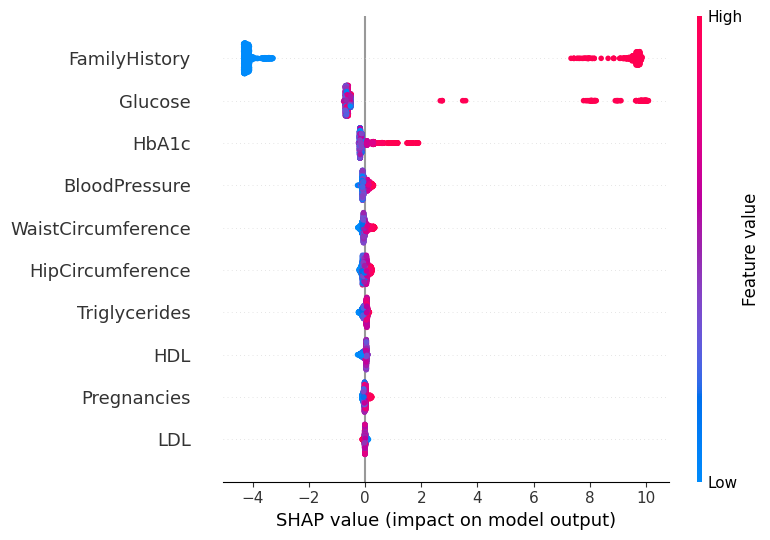

In [34]:
shap.summary_plot(shap_values, X_test)